# 时间序列分析第五次作业

姓名：欧阳瑞志、班级：统计22、学号：220403102

## 一、数据导入和平稳性检验
采用图检验，发现数据均值不为常数，显然不平稳，无需做ADF和纯随机检验，直接看图判断。

均值：4.799642857142857，方差：18.353946301020407


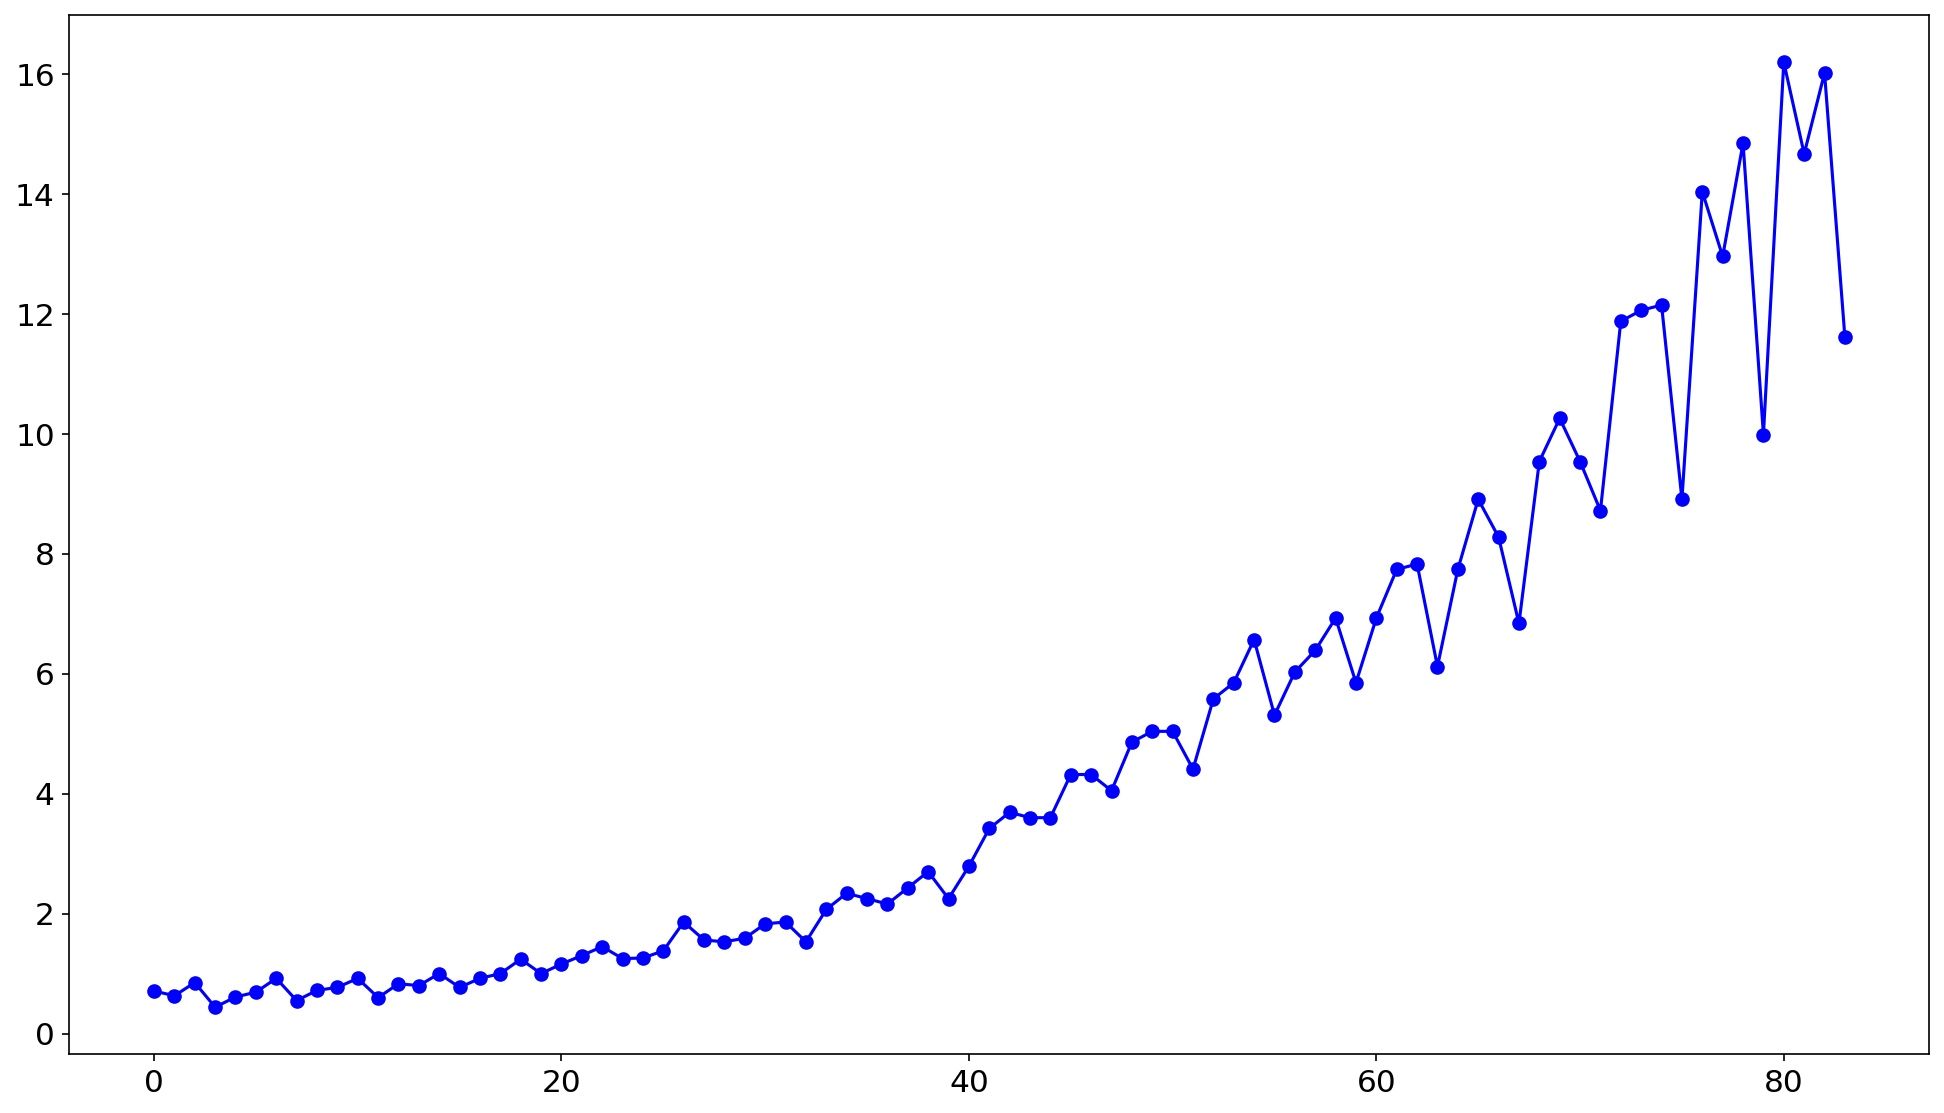

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
import pandas as pd
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf

# 数据导入并对数变换
data = [0.71, 0.63, 0.85, 0.44, 0.61, 0.69, 0.92, 0.55, 0.72, 0.77, 0.92, 0.6, 0.83, 0.8, 1, 0.77, 0.92, 1, 1.24, 1, 1.16, 1.3, 1.45, 1.25, 1.26, 1.38, 1.86, 1.56, 1.53, 1.59, 1.83, 1.86, 1.53, 2.07, 2.34, 2.25, 2.16, 2.43, 2.7, 2.25, 2.79, 3.42, 3.69, 3.6, 3.6, 4.32, 4.32, 4.05, 4.86, 5.04, 5.04, 4.41, 5.58, 5.85, 6.57, 5.31, 6.03, 6.39, 6.93, 5.85, 6.93, 7.74, 7.83, 6.12, 7.74, 8.91, 8.28, 6.84, 9.54, 10.26, 9.54, 8.72, 11.88, 12.06, 12.15, 8.91, 14.04, 12.96, 14.85, 9.99, 16.2, 14.67, 16.02, 11.61]

# 计算均值和方差
mean = np.mean(data)
variance = np.var(data)
print(f'均值：{mean}，方差：{variance}')

# 绘制序列图做平稳性检验
plt.figure(figsize=(16, 9), dpi=150)
plt.plot(data, linestyle='-', color='b', marker='o', markerfacecolor='b')
plt.xlabel('', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(fname='序列图.png')

## 二、一阶差分与季节差分
观察到，数据有趋势，有季节，为了解决不平稳的问题，采用一阶差分再进一步用季节为4的季节差分，并做ADF检验判断平稳性。（看着像是还有异方差，但ADF检验过了，不管了）

一阶差分后 ADF 检验统计量：-0.4074188426426683
p 值：0.9088527077259203
临界值（1%）：-3.524624466842421
临界值（5%）：-2.9026070739026064
临界值（10%）：-2.5886785262345677
季节性差分后 ADF 检验统计量：-6.5137001277923465
p 值：1.084466276237612e-08
临界值（1%）：-3.5232835753964475
临界值（5%）：-2.902030597326081
临界值（10%）：-2.5883710883843123
季节差分数据是平稳的。


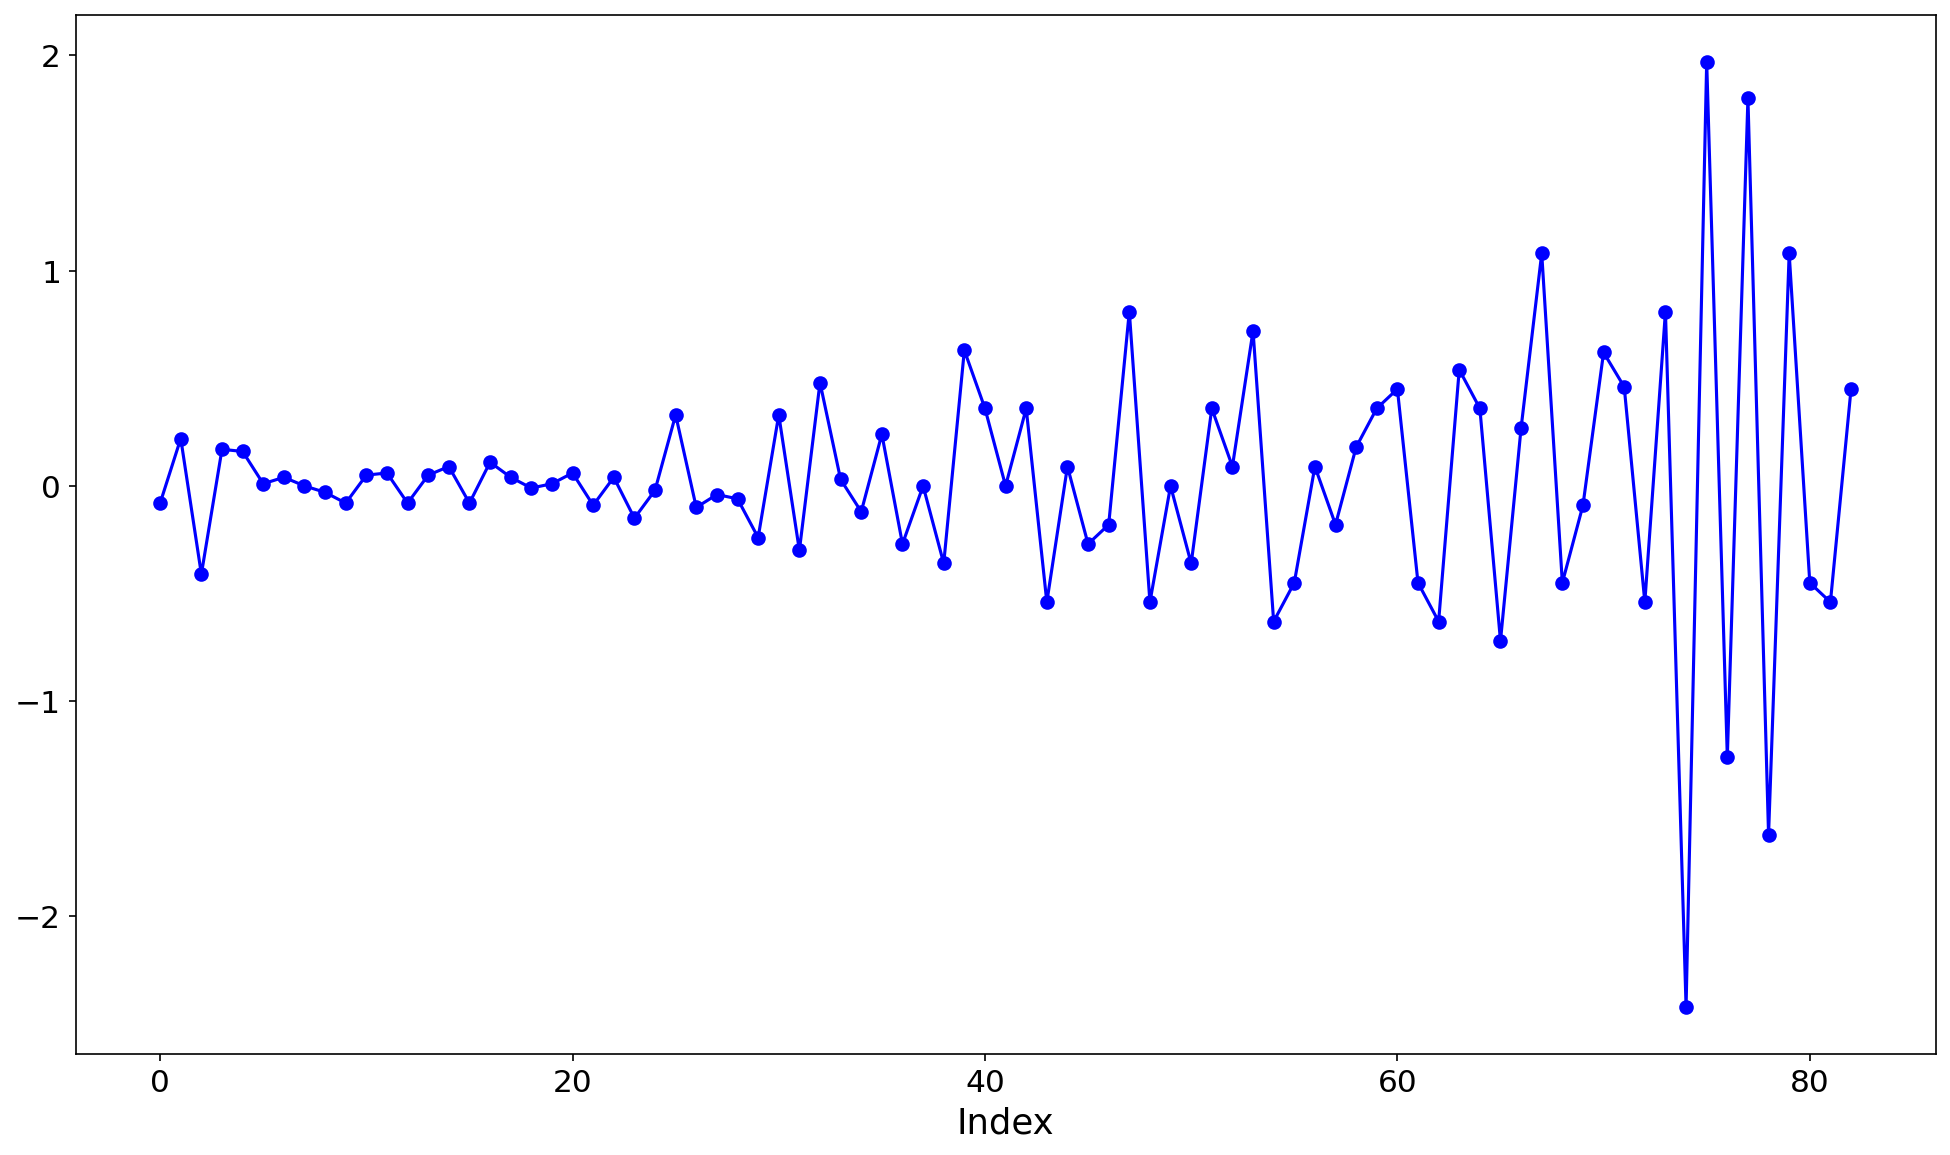

In [2]:
# 一阶差分
first_order_diff = np.diff(data)

# 对一阶差分后的数据做 ADF 检验
result_first_order = adfuller(first_order_diff, autolag='AIC')
print(f'一阶差分后 ADF 检验统计量：{result_first_order[0]}')
print(f'p 值：{result_first_order[1]}')
print(f'临界值（1%）：{result_first_order[4]["1%"]}')
print(f'临界值（5%）：{result_first_order[4]["5%"]}')
print(f'临界值（10%）：{result_first_order[4]["10%"]}')

# 季节性差分（季节数为 4）
seasonal_diff = np.array([first_order_diff[i] - first_order_diff[i - 4] if i >= 4 else first_order_diff[i] for i in range(len(first_order_diff))])

# 对季节性差分后的数据做 ADF 检验
result_seasonal = adfuller(seasonal_diff[4:], autolag='AIC')
print(f'季节性差分后 ADF 检验统计量：{result_seasonal[0]}')
print(f'p 值：{result_seasonal[1]}')
print(f'临界值（1%）：{result_seasonal[4]["1%"]}')
print(f'临界值（5%）：{result_seasonal[4]["5%"]}')
print(f'临界值（10%）：{result_seasonal[4]["10%"]}')

if result_seasonal[1] < 0.05:
    print('季节差分数据是平稳的。')
else:
    print('季节差分数据不是平稳的。')

# 绘制季节差分后的序列图
plt.figure(figsize=(16, 9), dpi=150)
plt.plot(seasonal_diff, linestyle='-', color='b', marker='o', markerfacecolor='b')
plt.xlabel('Index', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(fname='季节差分序列图.png')

## 三、纯随机检验
已经判断序列为平稳性数据，进一步判断是否为白噪声数据。  
原假设：$$H_0: \rho_1=\rho_2=\cdots=\rho_m=0, \forall m \geq 1$$  
备择假设：$$H_1: \rho_k \neq 0,  \forall m \geq 1, k \leq m$$  
LB统计量：$$LB=n(n+2) \sum_{k=1}^m\left(\frac{\hat{\rho}_k^2}{n-k}\right) \sim \chi^2(m)$$
从结果上来看，p值小于0.05，拒绝原假设，认为这一组序列为非白噪声序列，不具有纯随机性。

In [3]:
# 纯随机检验
LB = acorr_ljungbox(seasonal_diff, lags=range(1, 21), boxpierce=True, return_df=True)
print(LB)

      lb_stat     lb_pvalue    bp_stat     bp_pvalue
1   38.957112  4.332191e-10  37.582155  8.764262e-10
2   52.537523  3.905008e-12  50.523488  1.068966e-11
3   64.139799  7.662014e-14  61.443277  2.889631e-13
4   69.354289  3.106688e-14  66.289685  1.376268e-13
5   72.351347  3.318743e-14  69.039927  1.623196e-13
6   72.881034  1.047244e-13  69.519761  5.129527e-13
7   73.312091  3.155522e-13  69.905176  1.544075e-12
8   73.464822  1.000551e-12  70.039939  4.825260e-12
9   73.470005  3.166068e-12  70.044452  1.492438e-11
10  73.486770  9.366869e-12  70.058850  4.319278e-11
11  73.629570  2.481175e-11  70.179810  1.129201e-10
12  74.160791  5.292552e-11  70.623536  2.448063e-10
13  74.178302  1.353646e-10  70.637956  6.123697e-10
14  74.303394  3.175153e-10  70.739501  1.417460e-09
15  74.667962  6.500169e-10  71.031156  2.924592e-09
16  74.670221  1.496494e-09  71.032937  6.574566e-09
17  74.949058  2.981838e-09  71.249445  1.312826e-08
18  75.428943  5.336692e-09  71.616416  2.4028

## 四、模型识别
通过观察自相关函数和偏自相关函数，并使用auto_arima比较AIC来确定最佳模型。

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[4]             : AIC=100.773, Time=0.17 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=145.327, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=101.915, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=100.447, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=99.893, Time=0.02 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=100.445, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=100.997, Time=0.07 sec
 ARIMA(1,1,1)(0,1,0)[4]             : AIC=97.967, Time=0.02 sec
 ARIMA(1,1,1)(1,1,0)[4]             : AIC=99.933, Time=0.03 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=99.936, Time=0.03 sec
 ARIMA(1,1,1)(1,1,1)[4]             : AIC=101.927, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=99.954, Time=0.01 sec
 ARIMA(2,1,1)(0,1,0)[4]             : AIC=96.399, Time=0.03 sec
 ARIMA(2,1,1)(1,1,0)[4]             : AIC=98.341, Time=0.04 sec
 ARIMA(2,1,1)(0,1,1)[4]             : AIC=98.342, Time

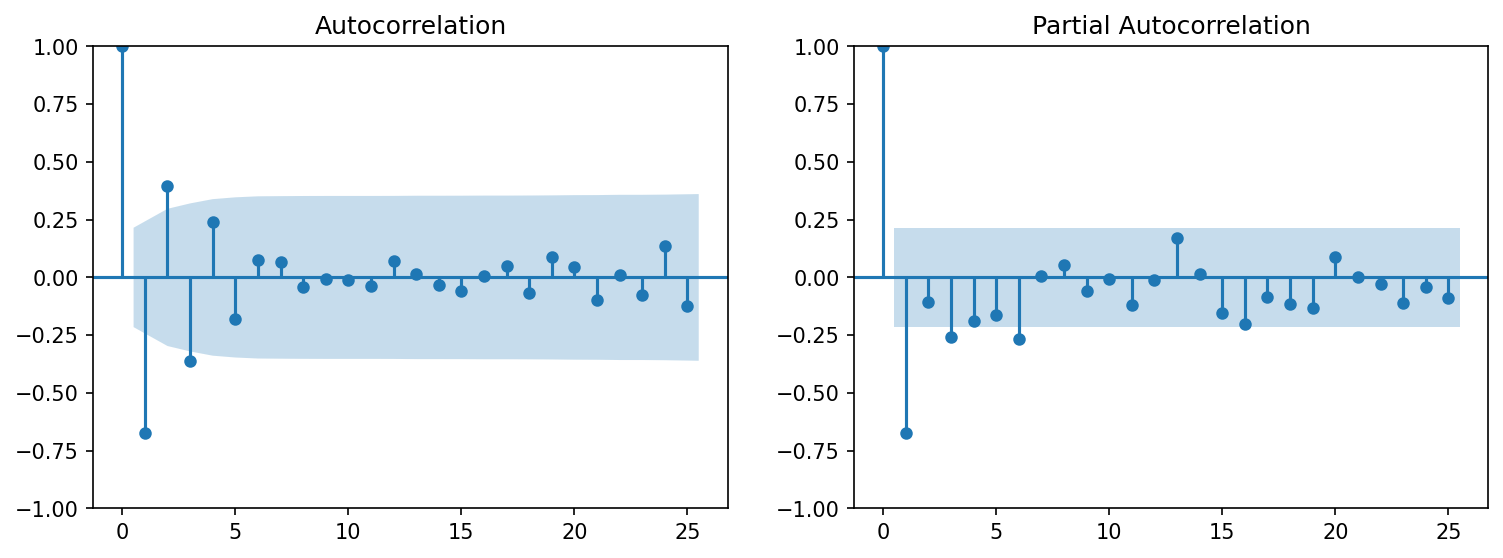

In [4]:
# 绘制自相关图和偏自相关图并识别模型
fig = plt.figure(figsize=(12, 4), dpi=150)
ax1 = fig.add_subplot(121)
sm.graphics.tsa.plot_acf(seasonal_diff, lags=25, ax=ax1)
ax2 = fig.add_subplot(122)
sm.graphics.tsa.plot_pacf(seasonal_diff, lags=25, ax=ax2)
plt.savefig(fname='相关图.png')

# 识别模型
series = pd.Series(data)
model = auto_arima(series, seasonal=True, m=4, trace=True)
print(f"自动识别的阶数：(p, d, q) = {model.order}")

虽然他写Best model是$SARIMA(3,1,1)(0,1,0)_4$，但其对应的AIC=inf，不知道为什么要选它。  
因此选最小的AIC是$SARIMA(3,1,2)(0,1,0)_4$，对应的AIC=95.928

## 五、参数估计与检验
被警报了  没关系  看不懂  不影响结果

In [5]:
## 参数估计
# 拟合模型
mod = sm.tsa.statespace.SARIMAX(data, order=(3,1,2), seasonal_order=(0,1,0,4))
res = mod.fit() 
print(res.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.28038D-01    |proj g|=  1.25999D+00

At iterate    5    f=  5.50161D-01    |proj g|=  3.85341D-01

At iterate   10    f=  5.27764D-01    |proj g|=  1.44406D-01

At iterate   15    f=  5.24245D-01    |proj g|=  1.82091D-03

At iterate   20    f=  5.24144D-01    |proj g|=  1.96179D-03

At iterate   25    f=  5.23249D-01    |proj g|=  6.87472D-02

At iterate   30    f=  5.15911D-01    |proj g|=  1.08883D-01

At iterate   35    f=  5.08856D-01    |proj g|=  5.80684D-02

At iterate   40    f=  5.02263D-01    |proj g|=  2.97594D-02

At iterate   45    f=  5.00696D-01    |proj g|=  8.49701D-03

At iterate   50    f=  4.99570D-01    |proj g|=  3.69783D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


参数估计的结果表明：其中一个参数p值大于0.05，不拒绝原假设，参数不显著；其他均通过检验

## 六、模型整体效果检验
通过通过验证模型对信息的提取是否充分，即残差是否为白噪声序列，来判断模型的整体效果。  
### 6.1判断标准化残差是否服从标准正态分布
检验：$$E(\epsilon_t)=0$$
$$D(\epsilon_t)=1$$
$$\epsilon_t服从N(0,1)$$
### 6.2残差的自相关函数
计算判断各个残差之间是否相关
### 6.3LB检验
原假设H0：这组数据为纯随机的，序列值之间相互独立。
$$
H_0: \rho_1=\rho_2=\cdots=\rho_m=0, \forall m \geq 1
$$  
备择假设H1：这组数据非白噪声序列，至少存在一个自相关系数不为零。
$$
H_1: \rho_k \neq 0,  \forall m \geq 1, k \leq m
$$  
采用LB统计量作为检验统计量：
$$
LB=n(n+2) \sum_{k=1}^m\left(\frac{\hat{\rho}_k^2}{n-k}\right) \sim \chi^2(m)
$$

残差序列： [ 0.71       -0.07999991  0.21999992 -0.40999988 -0.1850003   0.16000002
  0.12052119  0.05771557  0.05553186  0.00905358 -0.06469383  0.00559412
  0.07974956 -0.0595449  -0.02991201  0.10352644 -0.01209229  0.07695588
  0.15480178  0.07450739  0.05894646  0.10566932 -0.02573122 -0.03033416
 -0.15670928 -0.18986502  0.22652096  0.10037926 -0.06626555 -0.0172933
 -0.21775756  0.16016679 -0.09504899  0.21884398  0.34705272 -0.02848227
  0.25083474  0.01326929 -0.10890178 -0.36638586  0.24908332  0.67287874
  0.28567158  0.53336532  0.00210774 -0.03824441 -0.11146133 -0.45512043
  0.40717128 -0.21083341 -0.52396099 -0.45523791  0.04965696  0.36299598
  0.92624168  0.19288095 -0.5578314  -0.13074184 -0.26180561 -0.26515592
  0.11784938  0.48031856 -0.06450681 -0.68493919  0.29468548  0.87129574
 -0.30404239 -0.20023664  1.14761144  0.30685995 -0.29115921  0.64442817
  1.04210074  0.06777513  0.68061074 -1.64304231  0.0839367  -0.28361475
  0.49848941 -0.55678307 -0.05960108  0.446066

'\n子图1、标准化残差图，均值为0，方差为1\n子图2、残差自相关图，各残差之间不相关\n子图3、QQ图，为正态分布\n子图4、Ljung-Box统计量，p值大于0.05，不拒绝原假设认为残差为白噪声序列 \n'

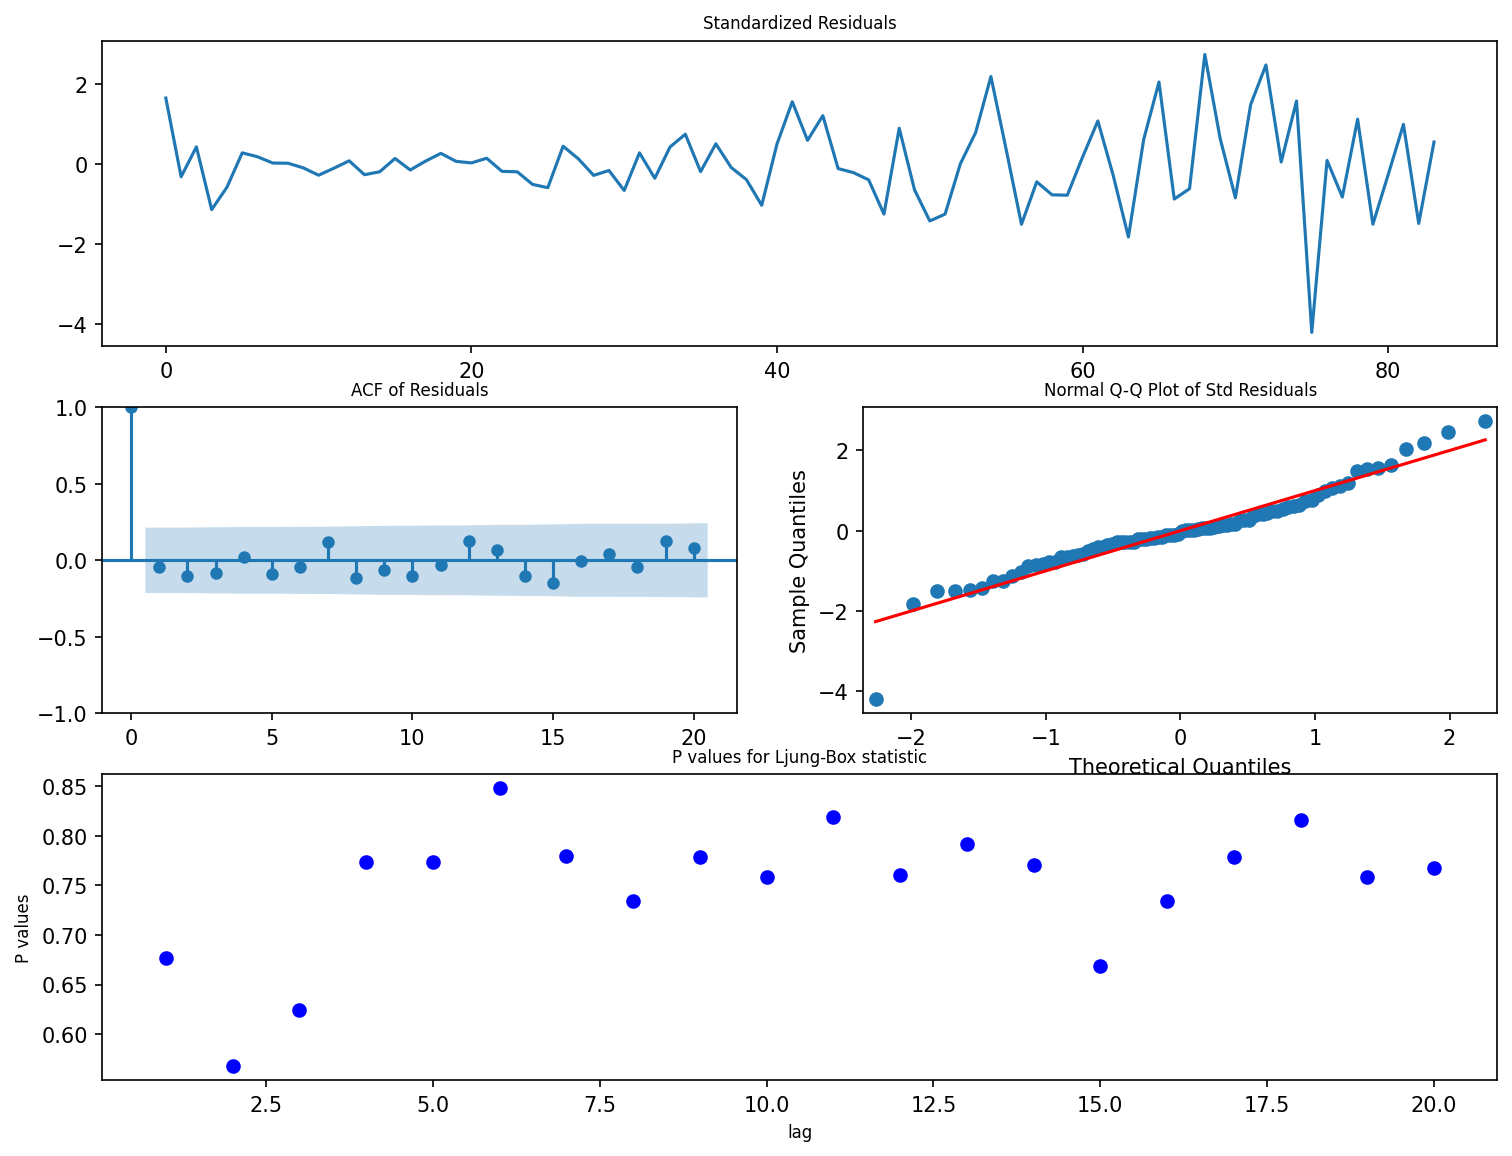

In [7]:
## 整体效果检验
# 计算残差序列
residuals = res.resid

# 输出残差序列
print("残差序列：", residuals)

# 检验残差序列为白噪声
LB = acorr_ljungbox(residuals, lags=range(1, 21), boxpierce=True, return_df=True)
print(LB)

resid_sd = (residuals-np.mean(residuals))/np.std(residuals)
fig = plt.figure(figsize=(12,9),dpi=150)  
ax1 = fig.add_subplot(311)  
ax1.plot(resid_sd);plt.title('Standardized Residuals', fontsize=8)  

ax2 = fig.add_subplot(323)  
plot_acf(residuals, ax=ax2)
plt.title('ACF of Residuals', fontsize=8)  

ax3 = fig.add_subplot(324)  
sm.qqplot(resid_sd, fit=True, line="s",ax=ax3)  
plt.title('Normal Q-Q Plot of Std Residuals', fontsize=8)  

lags = np.arange(1,21)
LB_p = LB.lb_pvalue
ax4 = fig.add_subplot(313)  
ax4.scatter(lags,LB_p,color="blue")
plt.xlabel(xlabel="lag", fontsize=8)  
plt.ylabel(ylabel="P values", fontsize=8)  
plt.title('P values for Ljung-Box statistic', fontsize=8)   
plt.savefig(fname='整体效果检验.png')

'''
子图1、标准化残差图，均值为0，方差为1
子图2、残差自相关图，各残差之间不相关
子图3、QQ图，为正态分布
子图4、Ljung-Box统计量，p值大于0.05，不拒绝原假设认为残差为白噪声序列 
'''

子图1为标准化残差图，观察可知推测均值为0，方差为1；子图2为残差自相关图，各残差之间不相关；子图3为Q-Q图，残差为为正态分布；子图4为Ljung-Box统计量，p值大于0.05，不拒绝原假设认为残差为白噪声序列

## 九、模型的预测
预测结果并给出90%和95的置信区间

        mean   mean_se   90%lower   90%upper   95%lower   95%upper
0  17.418285  0.409888  16.744079  18.092491  16.614919  18.221651
1  16.214652  0.413795  15.534019  16.895285  15.403628  17.025676
2  17.483029  0.469757  16.710348  18.255710  16.562323  18.403735
3  13.294857  0.472788  12.517190  14.072523  12.368210  14.221503


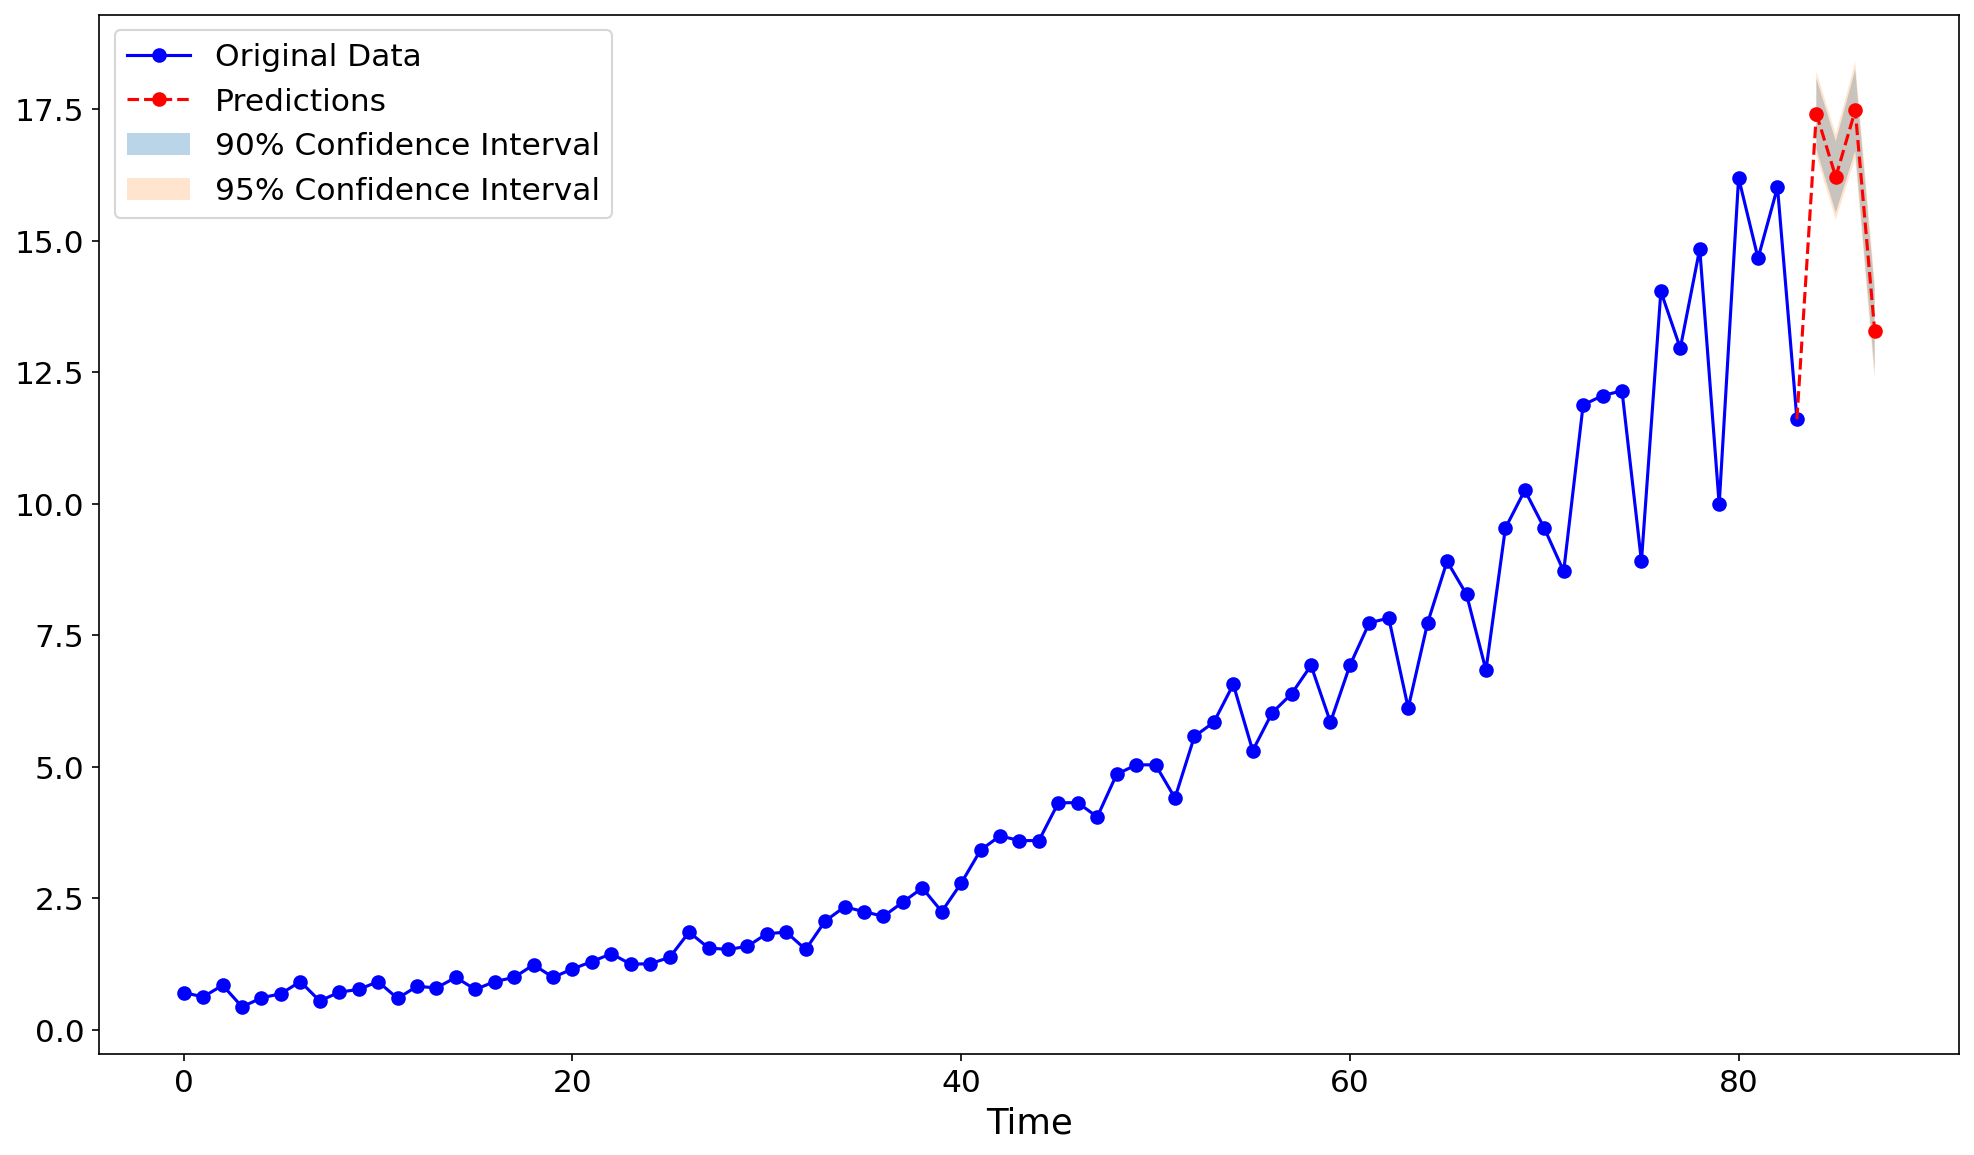

In [8]:
## 模型的预测
df_fore = res.get_forecast(steps=4)

confint1=df_fore.summary_frame(alpha=0.10)
confint2=df_fore.summary_frame(alpha=0.05).iloc[:,2:]
confint1.columns=["mean","mean_se","90%lower","90%upper"]
confint2.columns=["95%lower","95%upper"]
confint = pd.concat([confint1,confint2],axis=1,ignore_index=False)
print(confint)

plt.figure(figsize=(16, 9), dpi=150)
plt.plot(range(len(data)), data, linestyle='-', color='b', marker='o', markerfacecolor='b', label='Original Data')
plt.plot(range(len(data), len(data) + len(confint["mean"])), confint["mean"], linestyle='--', color='r', marker='o', markerfacecolor='r', label='Predictions')
plt.fill_between(range(len(data), len(data) + len(confint["mean"])), confint["90%lower"], confint["90%upper"], alpha=0.3, label='90% Confidence Interval')
plt.fill_between(range(len(data), len(data) + len(confint["mean"])), confint["95%lower"], confint["95%upper"], alpha=0.2, label='95% Confidence Interval')
last_data_index = len(data) - 1
last_pred_index = len(data)
plt.plot([last_data_index, last_pred_index], [data[last_data_index], confint["mean"][last_pred_index-len(data)]], linestyle='--', color='r')
plt.xlabel('Time', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig(fname='预测结果.png')